# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

В данном нам файле присутствуют такие столбцы, как. 
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя
- Price — цена (евро)

# обновление системы, установка библиотек

In [1]:
!pip install scikit-learn==1.4.2
!pip install matplotlib==3.5.0 -q
!pip install phik -q
!pip install shap -q

In [2]:
!pip install lightgbm


# загрузка библиотек 

In [3]:
import pandas as pd
import numpy as np 
import lightgbm as lgb
import seaborn as sns

import pyspark 

from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator, RegressionEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import phik


RANDOM_SEED = 27


## Изучение и подготовка данных.

# проверка версий 

In [4]:
import lightgbm
print(lightgbm.__version__)

3.3.1


# загрузка файла 

In [5]:
data = pd.read_csv('/datasets/autos.csv')

In [6]:
# информация о данных
data.info()
# выведим количесвто явных дубликатов 
print('')
print('сумма полных дублекатов',data.duplicated().sum())
print('')
# выведим 5 строк данныч
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [7]:
data.isna().sum().sort_values()

DateCrawled              0
Price                    0
RegistrationYear         0
Power                    0
Kilometer                0
RegistrationMonth        0
Brand                    0
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
Model                19705
Gearbox              19833
FuelType             32895
VehicleType          37490
Repaired             71154
dtype: int64

<br><font color='green'>- В <b>NumberOfPictures </b>пропусков нет. 
<br><font color='green'>- В<b> PostalCode</b> пропусков нет. 
<br> <font color='green'>- В столбце <b>Price</b> нет никаких проблем (пропуски отсутствуют). 
<br><font color='green'>- В <b>RegistrationYear</b> нет пропусков, столбец имеет тип int64, так можно и оставить. 
<br><font color='green'>- В <b>Power</b> пропусков нет. 
<br><font color='green'>- В <b>Kilometer</b> всё хорошо. 
<br><font color='green'>- В <b>RegistrationMonth</b> всё хорошо. 
<br><font color='green'>- В <b>FuelType</b> всё хорошо. 
<br><font color='green'>- В <b>Brand</b> всё хорошо. 
<br><font color='green'>- В <b>DateCreated</b>  пропусков в файле нет. 
<br><font color='green'>- В <b>LastSeen</b>  пропусков в файле нет.
    <br> <font color='green'>- Столбец <b>DateCrawled</b>  пропусков в файле нет. 
    
    
<br><font color='orange'>- В <b>Model</b> имеются пропуски, их также можно заменить, удалить, не трогать. 
<br><font color='orange'>- В <b>Repaired</b> самое большое количество пропусков 71154, в этом случае можем предположить, что пропуск обозначает «нет», есть риск, если изменить в таком количестве пропусков, можно сильно повлиять на исход ответа. 
    

   <br><font color='red'>- В <b>Gearbox</b> присутствует 19833 пропусков (их также можно не трогать или поменять на самое популярное, или удалить из файла, что лучше повлияет на модель).
<br> <font color='red'>- В <b>VehicleType</b> 37490 пропусков, которые можно не трогать, а можно заменить на значение, которое больше всего попадаеться (надо смотреть веса и пробовать сделать 2 модели с и без этих действий). 

In [8]:
data =data.drop_duplicates()
data.duplicated().sum()

0

In [9]:
data['DateCrawled'] = pd.to_datetime(data['DateCrawled'])
data['DateCreated'] = pd.to_datetime(data['DateCreated'])
data['LastSeen'] = pd.to_datetime(data['LastSeen'])





data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354365 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354365 non-null  datetime64[ns]
 1   Price              354365 non-null  int64         
 2   VehicleType        316875 non-null  object        
 3   RegistrationYear   354365 non-null  int64         
 4   Gearbox            334532 non-null  object        
 5   Power              354365 non-null  int64         
 6   Model              334660 non-null  object        
 7   Kilometer          354365 non-null  int64         
 8   RegistrationMonth  354365 non-null  int64         
 9   FuelType           321470 non-null  object        
 10  Brand              354365 non-null  object        
 11  Repaired           283211 non-null  object        
 12  DateCreated        354365 non-null  datetime64[ns]
 13  NumberOfPictures   354365 non-null  int64   

In [10]:
# в столбцах Model, Gearbox, FuelType, VehicleType, Repaired заполним пропуски заглушками unknown     
columns = ['Model', 'Gearbox', 'FuelType', 'VehicleType', 'Repaired'  ]
data[columns] = data[columns].fillna('unknown')
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,unknown,1993,manual,0,golf,150000,0,petrol,volkswagen,unknown,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,unknown,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,unknown,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21


Text(0.5, 1.0, 'количество скачивания анкеты из базы ')

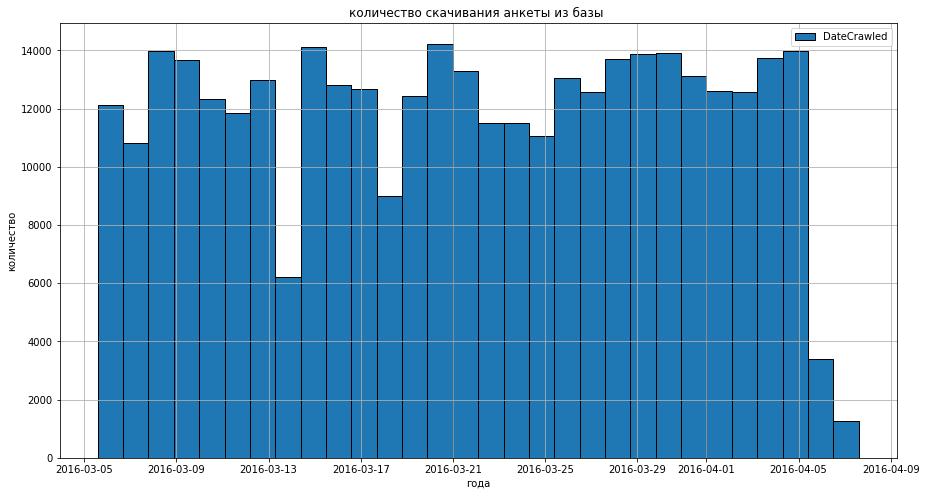

In [11]:
data['DateCrawled'].hist(bins=30 ,  figsize=(15, 8), ec='black', legend=True )
plt.xlabel('года')
plt.ylabel('количество')
plt.title('количество скачивания анкеты из базы ')

In [12]:
# посмотрим периуд за каторый скачивались данные 
minn = data['DateCrawled'].min()
maxx = data['DateCrawled'].max()
f'{minn} ---- {maxx}'

'2016-03-05 14:06:22 ---- 2016-04-07 14:36:58'

Временной отрезок короткий, и модель будет хуже показывать на датах, не входящих в этот диапазон. 

Text(0.5, 1.0, 'какое количество с какой суммой ')

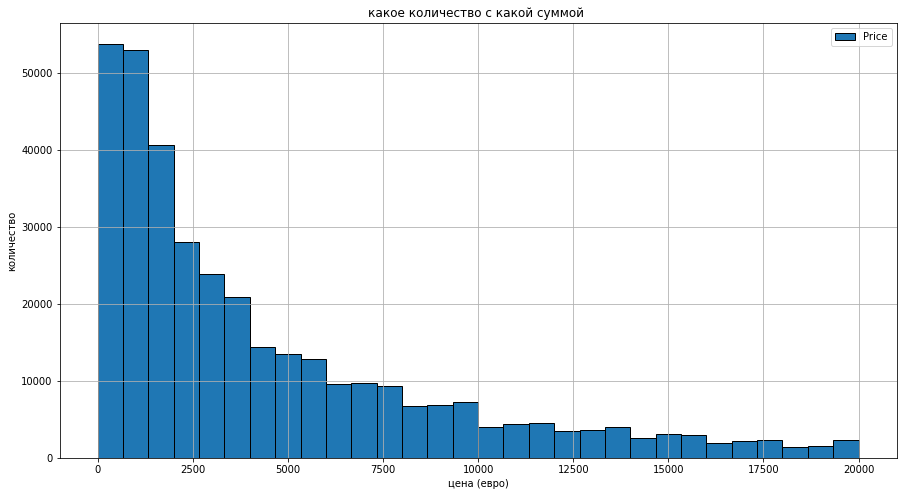

In [13]:
data['Price'].hist(bins=30 ,  figsize=(15, 8), ec='black', legend=True )
plt.xlabel('цена (евро)')
plt.ylabel('количество')
plt.title('какое количество с какой суммой ')

Видим диаграмму с большим длинным хвостом, что нормально, так как чем больше сумма, тем меньше таких машин.

In [14]:
data['VehicleType'].value_counts()

sedan          91457
small          79830
wagon          65165
unknown        37490
bus            28775
convertible    20203
coupe          16161
suv            11996
other           3288
Name: VehicleType, dtype: int64

In [15]:
data['RegistrationYear'].value_counts()

2000    24490
1999    22727
2005    22109
2001    20123
2006    19900
        ...  
4100        1
1200        1
5300        1
8888        1
2290        1
Name: RegistrationYear, Length: 151, dtype: int64

In [16]:
data['RegistrationYear'].min()

1000

есть ошибка в данных не может быть регестрация автомобиля после 2016 наши данные до 2016 года включительно.
Так же, как автомобиль навряд ли может зарегистрирован быть в 1000 г.

In [17]:
data = data[data['RegistrationYear'] <= 2016 ]
value = pd.DataFrame(data['RegistrationYear'].value_counts())
value[value['RegistrationYear'] == 1]


,RegistrationYear
1919,1
1253,1
1255,1
1602,1
1400,1
1915,1
1039,1
1920,1
1925,1
1927,1


In [18]:
data = data[data['RegistrationYear'] > 1949 ]
data['RegistrationYear'].value_counts()

2000    24490
1999    22727
2005    22109
2001    20123
2006    19900
        ...  
1953       14
1957       13
1951       12
1954       11
1952        9
Name: RegistrationYear, Length: 67, dtype: int64

Text(0.5, 1.0, 'какое количество с какой суммой ')

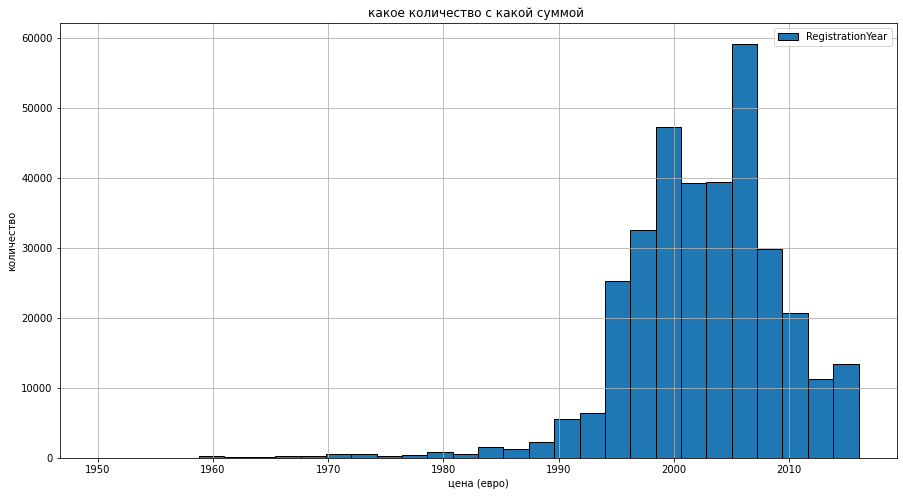

In [19]:
data['RegistrationYear'].hist(bins=30 ,  figsize=(15, 8), ec='black', legend=True )
plt.xlabel('цена (евро)')
plt.ylabel('количество')
plt.title('какое количество с какой суммой ')

Видим колокол с длинным хвостом слева (распределение нормальное).

In [20]:

data['Gearbox'].value_counts()

manual     257481
auto        64296
unknown     17812
Name: Gearbox, dtype: int64

(0.0, 800.0)

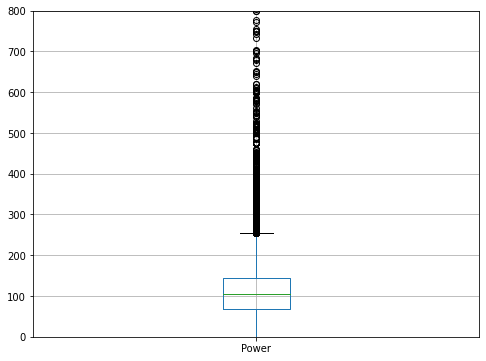

In [21]:
data.boxplot(column='Power', figsize=(8, 6))
plt.ylim(0,800)


Уберем все машины, которые по мощности больше 600 сил, с учетом, что есть редкие мощные автомобили. 

Text(0.5, 1.0, 'количество машин с той или иной мощностью ')

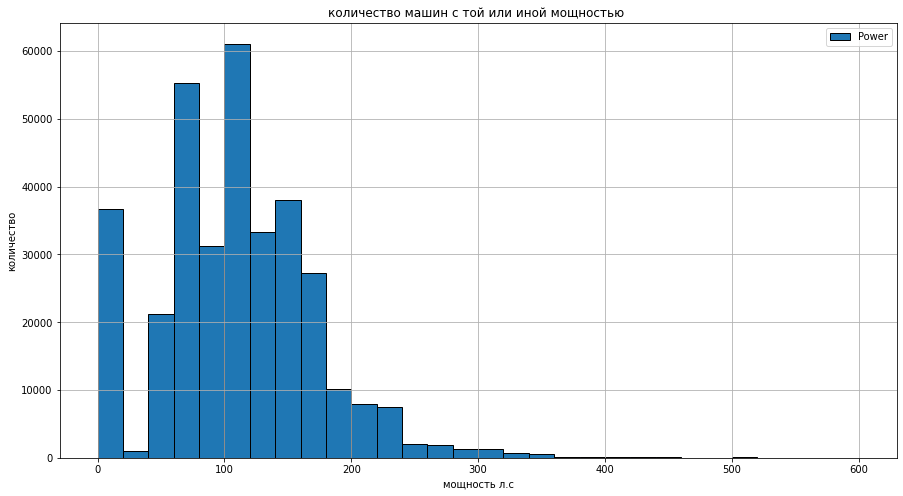

In [22]:
data = data[data['Power'] <= 600 ]
data['Power'].hist(bins=30 ,  figsize=(15, 8), ec='black', legend=True )
plt.xlabel('мощность л.с')
plt.ylabel('количество')
plt.title('количество машин с той или иной мощностью ')

В столбце Model ничего менять не будем, бывают и редкие модели, оставляем без изменений. 

Text(0.5, 1.0, 'количество машин с пробегом (км) ')

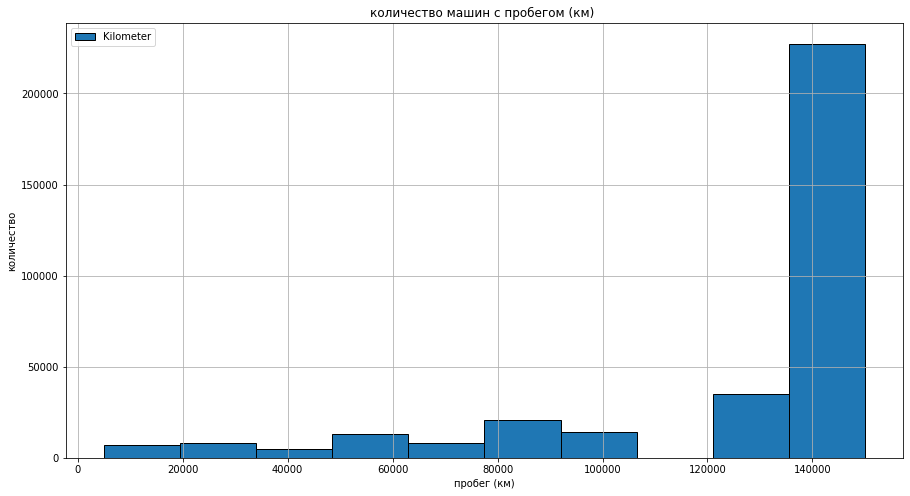

In [23]:
data['Kilometer'].hist(bins=10 ,  figsize=(15, 8), ec='black', legend=True )
plt.xlabel('пробег (км)')
plt.ylabel('количество')
plt.title('количество машин с пробегом (км) ')

 с данными о пробеше все хорошо
 

Text(0.5, 1.0, ' месяц регистрации автомобиля ')

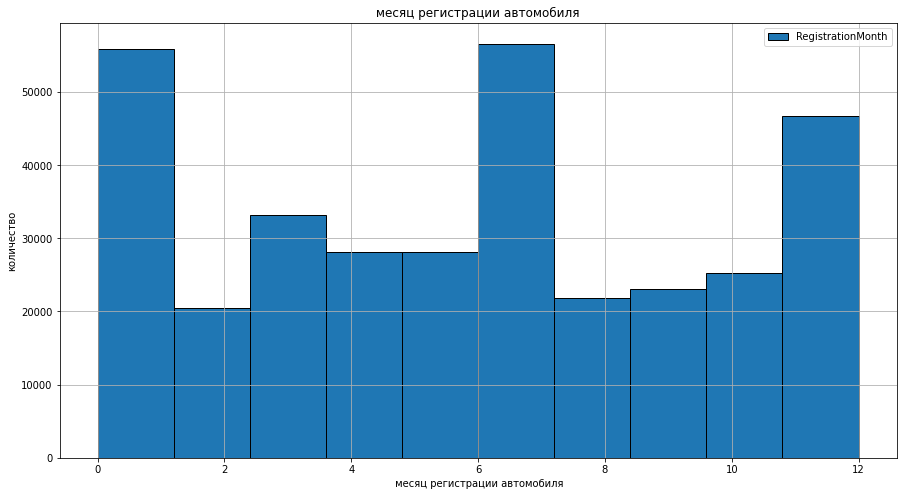

In [24]:
data['RegistrationMonth'].hist(bins=10 ,  figsize=(15, 8), ec='black', legend=True )
plt.xlabel(' месяц регистрации автомобиля')
plt.ylabel('количество')
plt.title(' месяц регистрации автомобиля ')

In [25]:
data['RegistrationMonth'].value_counts()

0     33477
3     33160
6     30349
4     28158
5     28105
7     26262
10    25233
12    23361
11    23357
9     23054
1     22404
8     21807
2     20514
Name: RegistrationMonth, dtype: int64

В данных присутствует заглушка как 0 месяц.

In [26]:
data['FuelType'].value_counts()

petrol      209719
gasoline     96226
unknown      27097
lpg           5155
cng            540
hybrid         224
other          192
electric        88
Name: FuelType, dtype: int64

С большой вероятностью наша зашлушка в виде unknown может быть petrol, но тогда к нему мы добавим целых 10%, что много, оставим как есть. 

In [27]:
data['Brand'].value_counts()

volkswagen        73094
opel              37931
bmw               35761
mercedes_benz     30969
audi              28448
ford              24123
renault           16906
peugeot           10614
fiat               9141
seat               6526
mazda              5396
skoda              5356
smart              5024
citroen            4898
nissan             4741
toyota             4455
hyundai            3445
volvo              3139
sonstige_autos     3128
mini               3091
mitsubishi         2905
honda              2685
kia                2362
suzuki             2246
alfa_romeo         2230
chevrolet          1697
chrysler           1389
dacia               874
daihatsu            780
porsche             747
subaru              740
jeep                646
trabant             570
land_rover          537
saab                514
daewoo              512
jaguar              500
rover               459
lancia              444
lada                218
Name: Brand, dtype: int64

Самая популярная марка — это Volkswagen, самая непопулярная — Lada, что в дальнейшем даст вероятность показать верно цену на Volkswagen, чем на остальные машины, и больше всего ошибок с Lada.

In [28]:
data['Repaired'].value_counts()

no         239875
unknown     64551
yes         34815
Name: Repaired, dtype: int64

Text(0.5, 1.0, ' дата создания анкеты ')

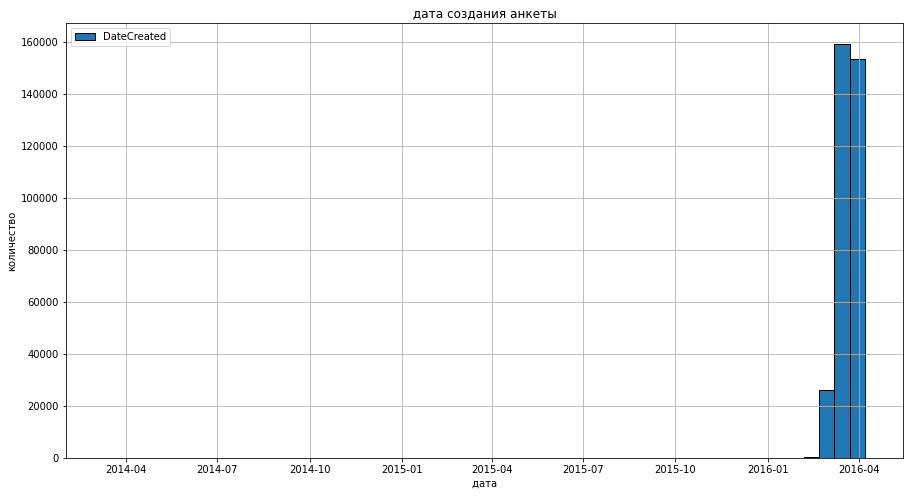

In [29]:
data['DateCreated'].hist(bins=50 ,  figsize=(15, 8), ec='black', legend=True )
plt.xlabel(' дата ')
plt.ylabel('количество')
plt.title(' дата создания анкеты ')

Из графика видно, что большинство исследуемых анкет в диапазоне 2016-01 до 2016-04. 

In [30]:
data['NumberOfPictures'].value_counts()

0    339241
Name: NumberOfPictures, dtype: int64

Данный столбец не несет никакой важности, удалим его. 

In [31]:
data = data.drop(columns = 'NumberOfPictures')
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,unknown,1993,manual,0,golf,150000,0,petrol,volkswagen,unknown,2016-03-24,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,unknown,125000,5,gasoline,audi,yes,2016-03-24,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,unknown,2016-03-14,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,60437,2016-04-06 10:17:21


In [32]:
data['PostalCode'].duplicated().sum()

331103

Данные данные нам никак не могут помочь с выявлением цены машины. 

In [34]:
data['LastSeen'].hist(bins =40, figsize = (15,8))
plt.xlabel('дата')
plt.ylabel('количество')
plt.title(' дата последней активности пользователя')

KeyError: 'LastSeen'

In [33]:
data = data.drop(columns = 'PostalCode', axis =1)
data = data.drop(columns = 'DateCreated', axis =1)
data = data.drop(columns = 'DateCrawled', axis =1)
data = data.drop(columns = 'LastSeen', axis =1)

Видно, что есть хвост из неактивных пользователей.

In [ ]:
#column = [  'LastSeen', 'Model', 'Gearbox', 'FuelType', 'VehicleType', 'Repaired',  'Brand'  ]
#plt.figure(figsize=(10, 8))
#sns.heatmap(data.drop(columns = column),  annot=True, cmap='coolwarm', square=True)
#plt.title('Phi_K Correlation Matrix')
#plt.show()

## Обучение моделей

In [35]:
# Разобьем на тестовую и обучающую выборку. 
#data = pd.get_dummies(data, drop_first=True)

X = data.drop(columns = 'Price', axis =1)
y = data.Price

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)
X_train.shape, X_test.shape

((271392, 10), (67849, 10))

In [36]:
X_test.head(1)

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
341218,suv,2006,auto,349,other,150000,3,lpg,chrysler,unknown


In [38]:
from sklearn.preprocessing import OneHotEncoder

In [39]:
ohe =OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)

In [41]:
ohe_column = ['VehicleType', 'Gearbox','Model' ,'FuelType','Brand','Repaired']

In [ ]:
X_train[ohe_column] = ohe.fit_transform(X_train[ohe_column])
X_train.head()

In [ ]:
from catboost import CatBoostClassifier

In [ ]:
cat_features = ['VehicleType','Gearbox' ,'Model','FuelType','Brand','Repaired']

model = CatBoostClassifier(loss_function='Logloss', iterations = 30)# < напишите код здесь >

model.fit(X_train, y_train,  verbose=10)

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
print(roc_auc_score(target_valid, probabilities_one_valid))

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
lgbm = lgb.LGBMClassifier()

lgb_grid = {
    'num_leaves': [31, 50],
    'max_depth': [-1, 10, 20],
    'learning_rate': [0.05, 0.1, 0.2],
    'n_estimators': [20, 40, 100]
}


lgb_search = GridSearchCV(lgbm, lgb_grid, cv=3, scoring='accuracy')
lgb_search.fit(X_train, y_train)

print("Наилучшие параметры для LightGBM:", lgb_search.best_params_)
print("Лучший результат LightGBM:", lgb_search.best_score_)

In [ ]:
rf = RandomForestClassifier()

rf_grid = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
}

rf_search = GridSearchCV(rf, rf_grid, cv=3, scoring='accuracy')
rf_search.fit(X_train, y_train)

print("Best parameters for Random Forest:", rf_search.best_params_)
print("Best score for Random Forest:", rf_search.best_score_)

## Анализ моделей

In [ ]:
lgbm_best = lgb.LGBMClassifier(**lgb_search.best_params_)
lgbm_best.fit(X_train, y_train)
y_pred_lgb = lgbm_best.predict(X_test)
accuracy_lgb = accuracy_score(y_test, y_pred_lgb)
print("Accuracy of LightGBM on test set:", accuracy_lgb)

In [ ]:
rf_best = RandomForestClassifier(**rf_search.best_params_)
rf_best.fit(X_train, y_train)
y_pred_rf = rf_best.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)

print("Accuracy of Random Forest on test set:", accuracy_rf)

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Выполнена загрузка и подготовка данных
- [ ]  Выполнено обучение моделей
- [ ]  Есть анализ скорости работы и качества моделей